In [2]:
from qulacs import QuantumState,QuantumCircuit
from qulacs import ParametricQuantumCircuit
from qulacs.gate import RY,CZ,merge
from qulacs.state import inner_product
import numpy as np 
import random

import matplotlib.pyplot as plt

### Prepare training/test data
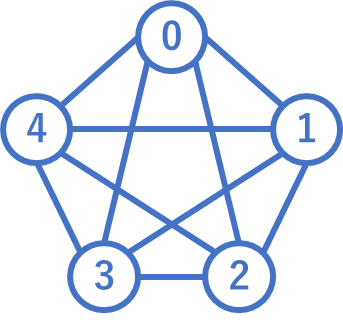

copied from Noro-san's code

In [4]:
n_qubits = 5

# 用いるスタビライザー群の要素を決定する
# 生成元 XZZZZ, ZXZZZ, ZZXZZ, ZZZXZ, ZZZZX 
S = np.zeros((n_qubits, 2*n_qubits))
S[0] = np.array([1,0, 0,1, 0,1, 0,1, 0,1]) # XZZZZ (X->1,0 Z->0,1 I->0,0としてならべる)
S[1] = np.array([0,1, 1,0, 0,1, 0,1, 0,1]) # ZXZZZ
S[2] = np.array([0,1, 0,1, 1,0, 0,1, 0,1]) # ZZXZZ
S[3] = np.array([0,1, 0,1, 0,1, 1,0, 0,1]) # ZZZXZ
S[4] = np.array([0,1, 0,1, 0,1, 0,1, 1,0]) # ZZZZX

def x_generator(c, select_bin_i):
    SS = np.copy(S)
    
    #select = np.random.randint(0,2,n_qubits) # i番目の生成元を使う(1)か使わない(0)かを決める行列
    se = np.zeros(n_qubits)
    for j in range(n_qubits):
        se[j] = int(select_bin_i[j])
        
    for i in range(n_qubits):
        SS[i] = SS[i] * se[i]
    op = np.sum(SS, axis=0) # それぞれのビットにそれぞれのゲート(X, Z)が何回掛かるかを示す行列

    # \theta_{+-}を計算する
    theta = np.zeros(2*n_qubits)

    for i in range(n_qubits):
        theta[2*i] = c[2*i] + np.pi/2 * op[2*i]
        theta[2*i+1] = (-1)**op[2*i] * c[2*i+1] + np.pi/2 * op[2*i+1]

    for i in range(2*n_qubits): # 0～\piの値にする
        theta[i] = theta[i] % np.pi
    
    return theta

In [54]:
random.seed(0)
n_data_train = 10
epsilon = 0.0 # エラーの分散

l = [i for i in range(2**n_qubits)] # 0 = 2**n_qubits-1 のリスト
select = random.sample(l, n_data_train)
select_bin = [format(select[i], f'0{n_qubits}b') for i in range(n_data_train)]

# c_{+-}を決める
c_plus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4 # - \pi/4 ～ \pi/4 のランダムな数
c_minus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4

x_plus = []
x_minus = []
#x_plus = x_generator(c_plus, select_bin[0]).reshape((1,-1))
#x_minus = x_generator(c_minus, select_bin[0]).reshape((1,-1))
for i in range(n_data_train):
    xx = x_generator(c_plus, select_bin[i]).reshape((1,-1))
    e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
    x_plus.append(xx + e)
    xx = x_generator(c_minus, select_bin[i]).reshape((1,-1))
    e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
    x_minus.append(xx + e)
x_plus = np.concatenate(x_plus)
x_minus = np.concatenate(x_minus)
x_train = np.concatenate([x_plus,x_minus])
y_plus = np.ones(n_data_train)
y_minus = -np.ones(n_data_train)
y_train = np.concatenate([y_plus, y_minus]).reshape(1,-1)
#print(x_train)
#print(y_train)

In [55]:
y_train = y_train.T

In [56]:
x_train.shape

(20, 10)

### Create helper function to get fiducial states, kernel matrix

In [57]:
def create_featured_gate(n_qubits,Lambda,edges,x):
    circuit = ParametricQuantumCircuit(n_qubits)
    for i in range(n_qubits):
        circuit.add_parametric_RY_gate(i,-Lambda[i])
    for control, target  in edges:
        circuit.add_CZ_gate(control,target)

    for i in range(n_qubits):
        circuit.add_RZ_gate(i,x[2*i])
        circuit.add_RX_gate(i,x[2*i+1])

    return circuit


In [58]:
edges= [[0,1],[1,2],[1,3],[3,4]]

In [59]:
def get_kernel_value(x1,x2,Lambda):

    state1 = QuantumState(n_qubits)
    state2 = QuantumState(n_qubits)
    state1.set_zero_state()
    state1.set_zero_state()

    circuit1 = create_featured_gate(n_qubits,Lambda,edges,x1)
    circuit2 = create_featured_gate(n_qubits,Lambda,edges,x2)
    
    circuit1.update_quantum_state(state1)

    circuit2.update_quantum_state(state2)

    return abs(inner_product(state1,state2))**2
    

In [60]:
def construct_kernel_matrix(Lambda,x):

    kernel_matrix = np.identity(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(i):
            kernel_matrix[i,j] = get_kernel_value(x[i],x[j],Lambda)
            kernel_matrix[j,i] = kernel_matrix[i,j].conjugate()
    
    return kernel_matrix

### Define helper function for cvxopt

In [61]:
from cvxopt import matrix, solvers

In [62]:
def cvxopt_solver(Kernel,y,C):
    
    P = matrix(np.outer(y,y) * Kernel )
    q = matrix(- np.ones(y.shape[0]))
    n = Kernel.shape[0] 

    G = matrix(np.vstack(( - np.eye(n), np.eye(n)  ))) 
    h = matrix(np.vstack((np.zeros((n, 1)), np.full((n, 1),C) )))
    A = matrix(y, (1,n))
    b = matrix(np.zeros(1), (1, 1))

    solvers.options["maxiters"] = 10000
    solvers.options["show_progress"] = False

    sol = solvers.qp(P,q,G,h,A,b)
    return sol 

## Kernel alignment programme

In [63]:
C = 1 
P = 20 # the number of steps for SPSA
### SPSA parameters. 
c = 0.1
gamma = 0.101
a = 0.05
A = 1
sigma = 0.602

lam0 = .1
lam_history = []
F_history = []
K_history = []
alpha_history = []


np.random.seed(1111)

lam = np.full(n_qubits, lam0)
for i in range(P):

    c_i =  c / (i + 1)** gamma
    a_i = a / ( i + 1 + A)** sigma

    Delta = 2*np.random.randint(0, 2, 1) - 1 
    lam_plus = lam + c_i * Delta
    lam_minus = lam - c_i * Delta

    K = construct_kernel_matrix(lam, x_train)
    K_plus = construct_kernel_matrix(lam_plus, x_train)
    K_minus = construct_kernel_matrix(lam_minus, x_train)

    sol = cvxopt_solver(K,y_train,C)
    sol_plus = cvxopt_solver(K_plus,y_train,C)
    sol_minus = cvxopt_solver(K_minus,y_train,C)
    alpha_plus = np.array(sol_plus['x']).reshape(-1)
    alpha_minus = np.array(sol_minus['x']).reshape(-1)
    alpha = sol['x']

    F_plus = - sol_plus['primal objective']
    F_minus = - sol_minus['primal objective']
    F = - sol['primal objective']
    lam = lam - (F_plus - F_minus)* Delta* a_i / (2 *c_i)
    lam_history.append(lam[0])
    F_history.append(F)
    K_history.append(K)
    alpha_history.append(alpha)


In [64]:
print(lam_history[-1])
print(alpha_history[-1])
a = alpha_history[-1]
print(alpha[0])

0.385977270296317
[ 6.96e-02]
[ 6.69e-01]
[ 5.53e-01]
[ 1.31e-07]
[ 7.58e-01]
[ 1.49e-01]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 3.74e-01]
[ 1.00e+00]
[ 3.92e-01]
[ 1.99e-01]
[ 8.74e-06]
[ 7.59e-01]
[ 6.12e-01]
[ 1.00e+00]
[ 1.00e+00]
[ 3.31e-07]
[ 6.12e-01]

0.06963391960319282


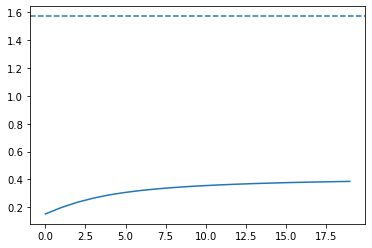

In [65]:

x = np.arange(0,P,1)
y = np.array(lam_history)
plt.plot(x,y)
plt.axhline(np.pi/2,linestyle='--')
plt.show()

## トレーニングデータでの確認

In [66]:
def predict(alpha, y_train, x_train, z, Lambda):
    kernel_value = np.zeros(len(x_train))
    for i in range(len(x_train)):
        kernel_value[i] = y_train[i] * alpha[i] * get_kernel_value(x_train[i], z, Lambda)
    return np.sign(np.sum(kernel_value))

In [67]:
predict_train = []
lam_vector = np.full(n_qubits, lam_history[-1])
for i in range(len(x_train)):
    predict_train.append(predict(alpha_history[-1], y_train, x_train, x_train[i], lam_vector))
print(predict_train)
print(y_train.reshape(-1))
print(predict_train - y_train.reshape(-1))
print(np.sum(np.abs(predict_train - y_train.reshape(-1)))/2)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0


## テストデータでの確認

テストデータ生成

In [68]:
n_data_test = 20
epsilon = 0.0 # エラーの分散

l = [i for i in range(2**n_qubits)] # 0 = 2**n_qubits-1 のリスト
select = random.sample(l, n_data_test)
select_bin = [format(select[i], f'0{n_qubits}b') for i in range(n_data_test)]

x_plus = []
x_minus = []
for i in range(n_data_test):
    xx = x_generator(c_plus, select_bin[i]).reshape((1,-1))
    e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
    x_plus.append(xx + e)
    xx = x_generator(c_minus, select_bin[i]).reshape((1,-1))
    e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
    x_minus.append(xx + e)
x_plus = np.concatenate(x_plus)
x_minus = np.concatenate(x_minus)
x_test = np.concatenate([x_plus,x_minus])
y_plus = np.ones(n_data_test)
y_minus = -np.ones(n_data_test)
y_test = np.concatenate([y_plus, y_minus]).reshape(1,-1)
#print(x_test)
#print(y_test)

In [69]:
predict_test = []
lam_vector = np.full(n_qubits, lam_history[-1])
for i in range(len(x_test)):
    predict_test.append(predict(alpha_history[-1], y_train, x_train, x_test[i], lam_vector))
print(predict_test)
print(y_test.reshape(-1))
print(predict_test - y_test.reshape(-1))
print(np.sum(np.abs(predict_test - y_test.reshape(-1)))/2)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0


## Under construction...

In [30]:
class KernelMatrix:

    def __init__(self,n_qubit,Lambda,edges) -> None:
        self.n_qubit = n_qubit
        self.Lambda = Lambda
        self.edges = edges
        self.state1 = QuantumState(n_qubit)
        self.state2 = QuantumState(n_qubit)

    def make_fiducial_state(self,Lambda):
        circuit = ParametricQuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_parametric_RY_gate(Lambda)
        for control, target in self.edges:
            circuit.add_CZ_gate(control,target)
        return circuit

    def create_featured_gate(self,theta):
        circuit = ParametricQuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_parametric_RY_gate(i,self.Lambda)
        for control, target in self.edges:
            circuit.add_CZ_gate(control,target)

        for i in range(self.n_qubit):
            circuit.add_RZ_gate(i,theta[i,0])
            circuit.add_RX_gate(i,theta[i,1])

        return circuit
        
    def featured_gate(self,theta):
        circuit = QuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_RZ_gate(i,theta[i,0])
            circuit.add_RX_gate(i,theta[i,1])

        return circuit

    def get_kernel_value(self,x1,x2):
        self.state1.set_zero_state()
        self.state1.set_zero_state()
        fiducial_gate = self.make_fiducial_state()


        featured_gate1 = self.featured_gate(x1)
        featured_gate2 = self.featured_gate(x2)
        
        circuit1 = merge(fiducial_gate,featured_gate1)
        circuit1.update_quantum_state(state1)
        circuit2 = merge(fiducial_gate,featured_gate2)
        circuit2.update_quantum_state(state2)

        return inner_product(state1,state2)
    
    def construct_kernel_matrix(self,x_data):
        """
        Args:
            x_data : MxNxD array of data where N is the number of samples,
             N the number of qubits, D the feature dimension
        """
        kernel_matrix = np.identity(x_data.shape[0])
        for i in range(x_data.shape[0]):
            for j in range(i):
                kernel_matrix[i,j] = self.get_kernel_value(x_data[i],x_data[j])
                kernel_matrix[j,i] = kernel_matrix[i,j].conjugate()
        
        return kernel_matrix

    def spsa(self,x_data,y_label,n_step,initial_Lambda = 0.01):
        Lambda = initial_Lambda
        for i in n_step:
            Delta = 2 * np.random.rand() - 1

            c_i = c / ( i + 1)**gamma
            Lambda__pm_i = Lambda + np.array([Delta*c_i, - Delta*c_i])
            self.construct_kernel_matrix()



In [43]:
np.array([0,1 ]) + 1

array([1, 2])

In [33]:
KernelMatrix(2,np.pi,[[0,1]]).state1

 *** Quantum State ***
 * Qubit Count : 2
 * Dimension   : 4
 * State vector : 
(1,0)
(0,0)
(0,0)
(0,0)

In [ ]:
state1 = QuantumState(n)
state2 = QuantumState(n)
def get_kernel_value(x1,x2):
    state1.set_zero_state()
    create_featured_gate()